In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
df_raw = pd.read_csv('dat/online_shoppers_intention.csv.gz')
print (df_raw.shape)
print (df_raw.columns)
df_raw.head()

(12330, 18)
Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [56]:
df_raw.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

Let's separate the test set in the very beginning, and never use it till the very end. 10% gives us 190 samples for the rare class, it should be enough.

In [57]:
from sklearn.model_selection import train_test_split
df, df_test = train_test_split(df_raw, test_size=0.1, stratify=df_raw.Revenue, random_state=42)
print ('df shape:', df.shape)
print ('df_test shape:', df_test.shape)

df shape: (11097, 18)
df_test shape: (1233, 18)


## Task 1 - Classification

#### 1.1 EDA


In [58]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000
mean,2.315310,80.702285,0.504461,34.458648,31.546634,1188.251018,0.022272,0.043206,5.894389,0.062179,2.128503,2.362981,3.157069,4.069208
std,3.309821,176.632641,1.280012,141.020772,43.637604,1891.000234,0.048535,0.048631,18.654673,0.200535,0.918191,1.733921,2.400531,4.020483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,183.708333,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.000000,0.003125,0.025305,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,92.833333,0.000000,0.000000,38.000000,1471.858333,0.017188,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


                                             |          | [  0%]   00:00 -> (? left)


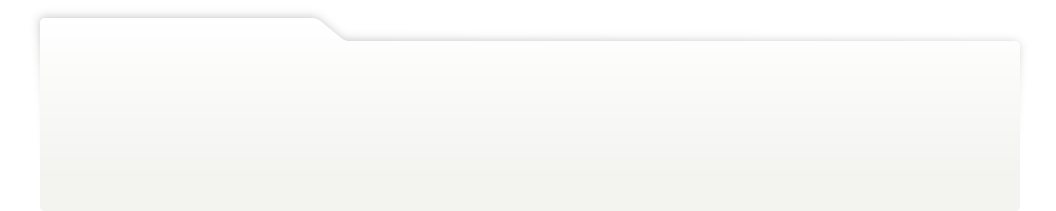
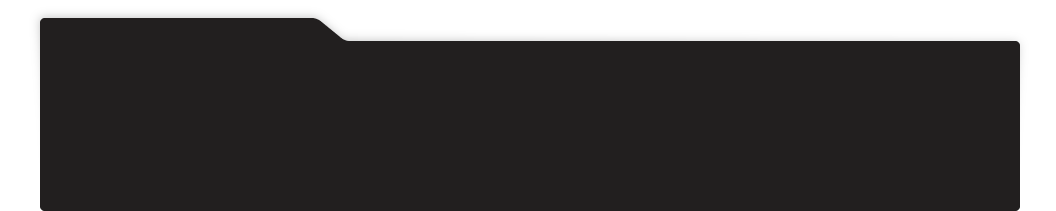
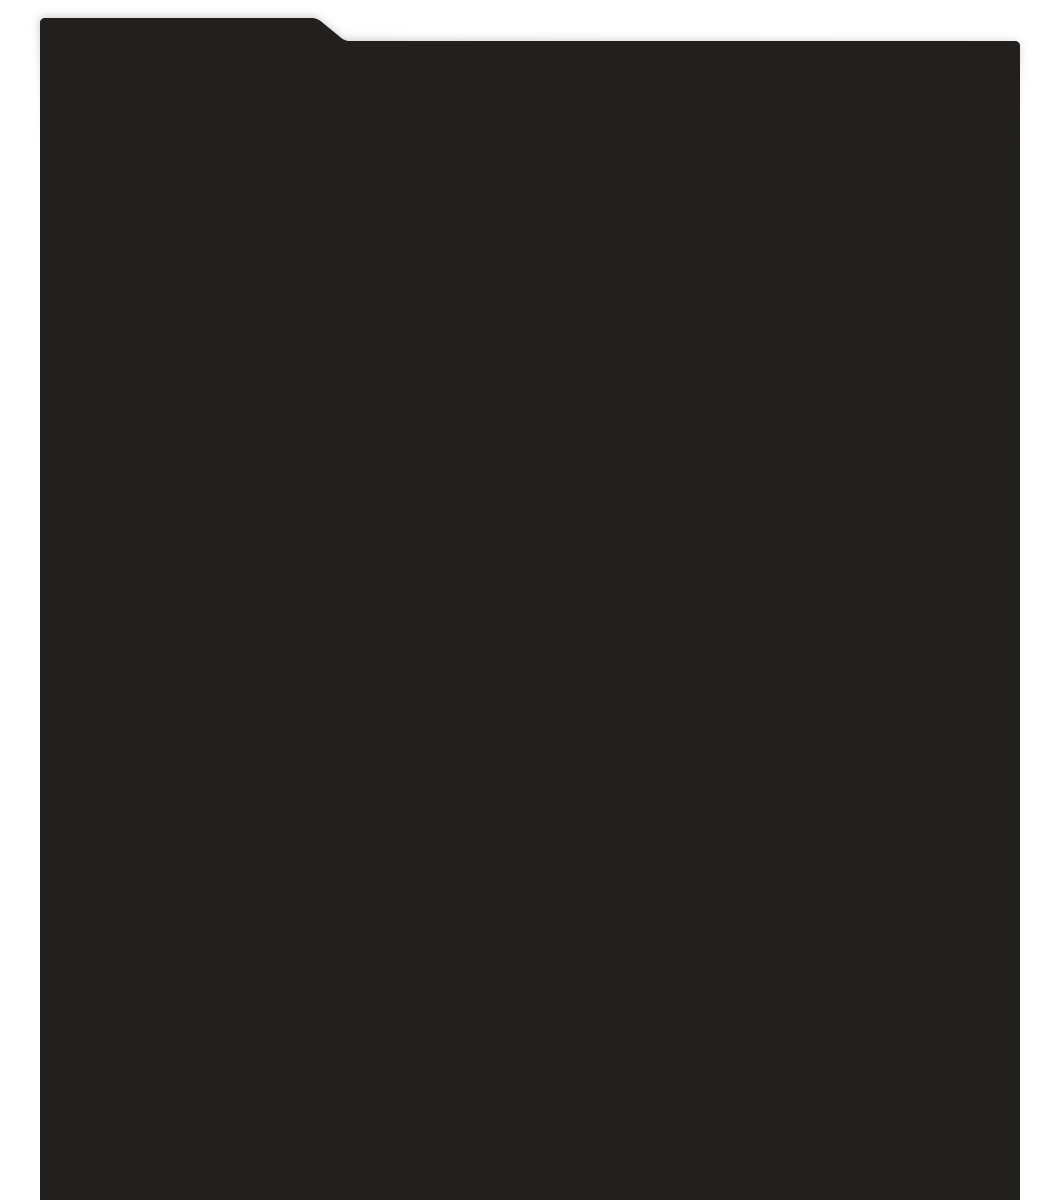
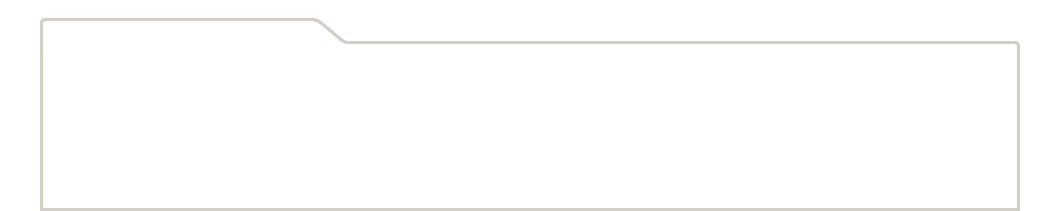
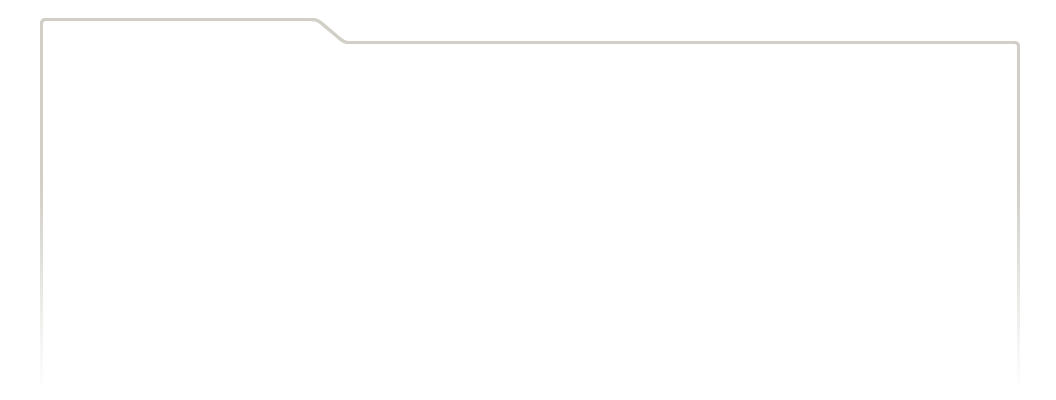
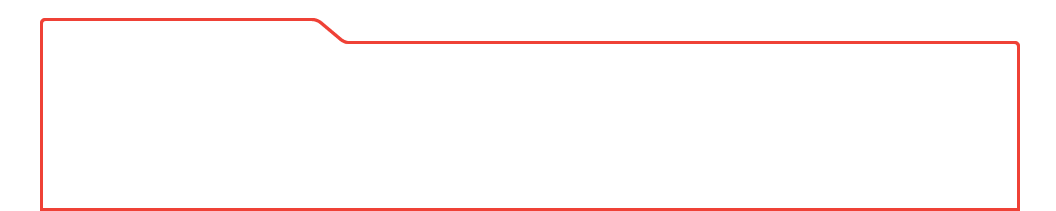
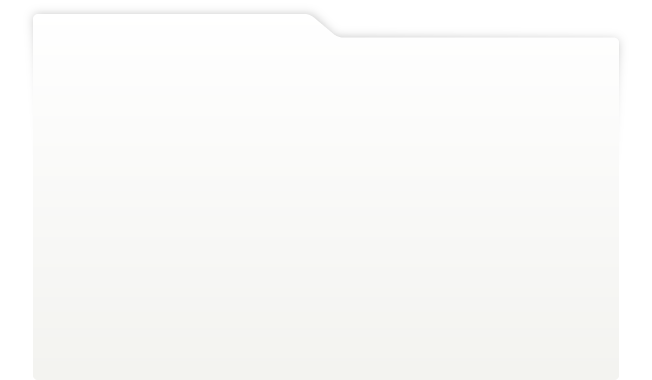
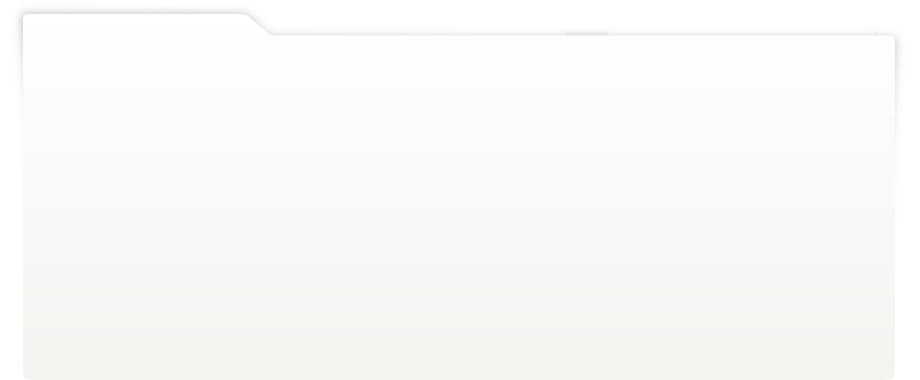
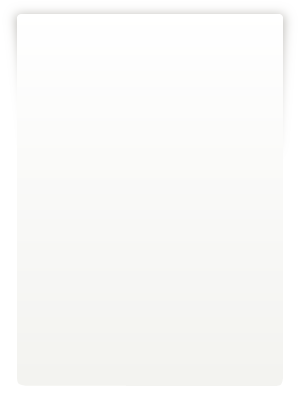
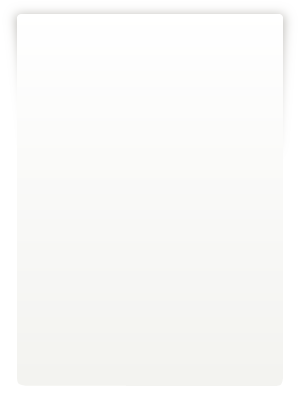
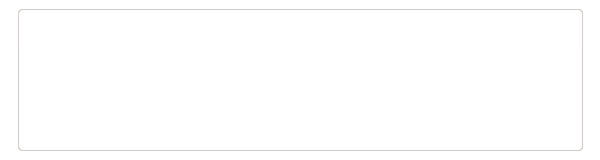
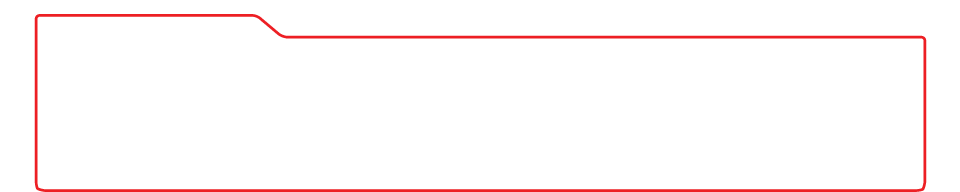
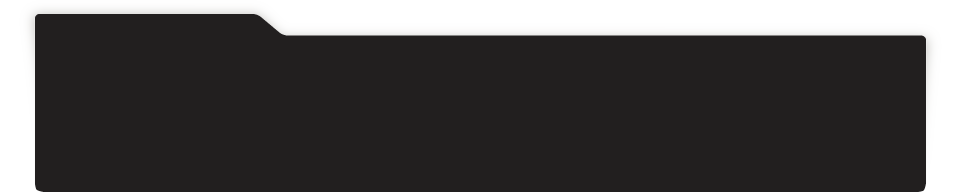
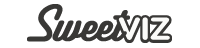
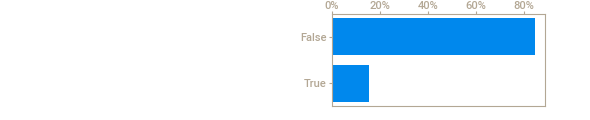
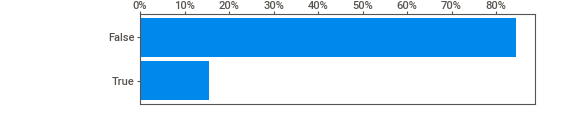
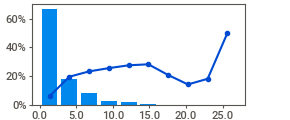
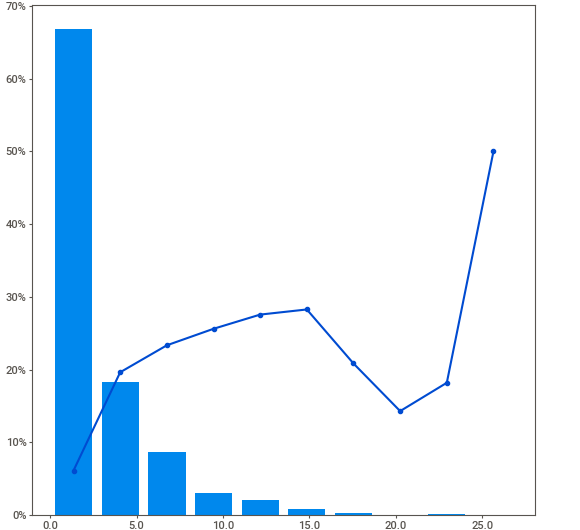
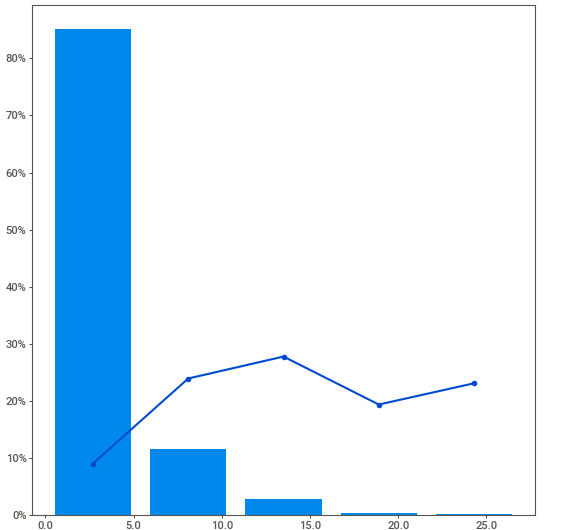
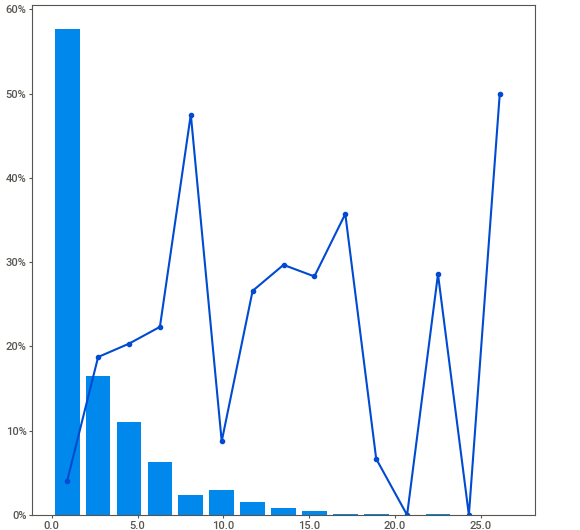
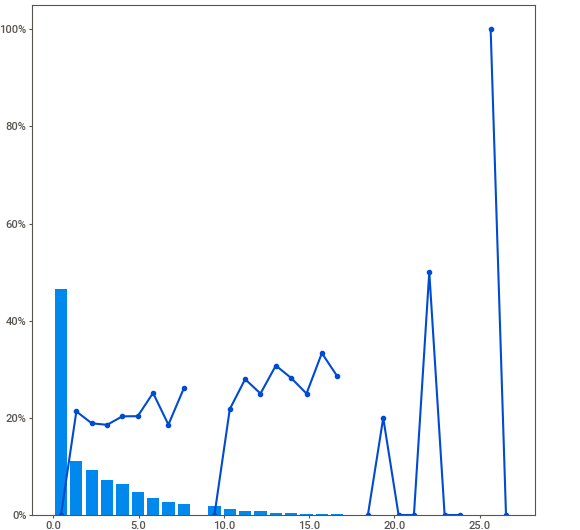
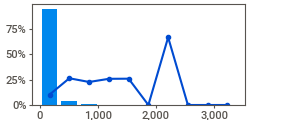
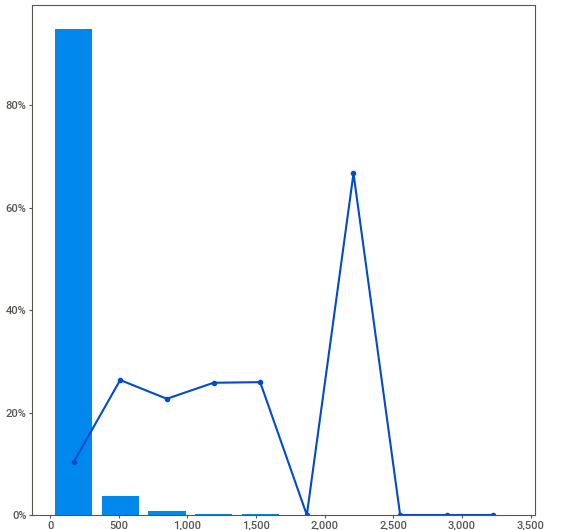
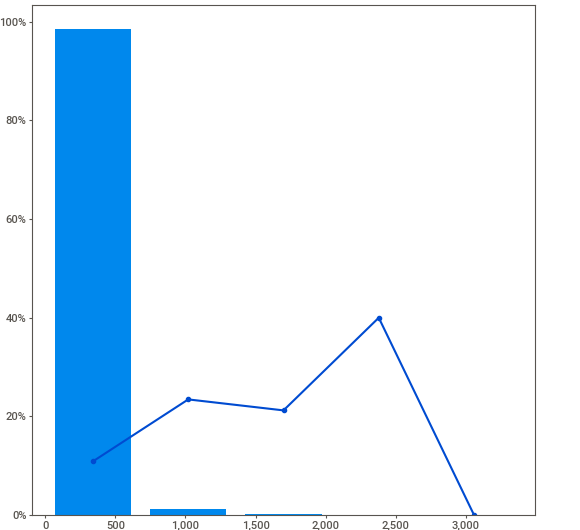
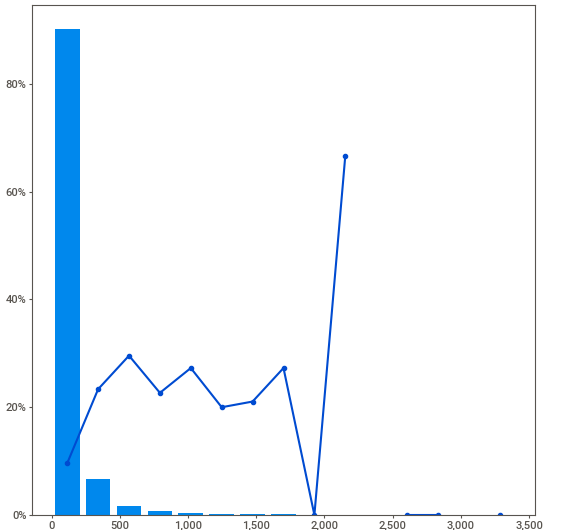
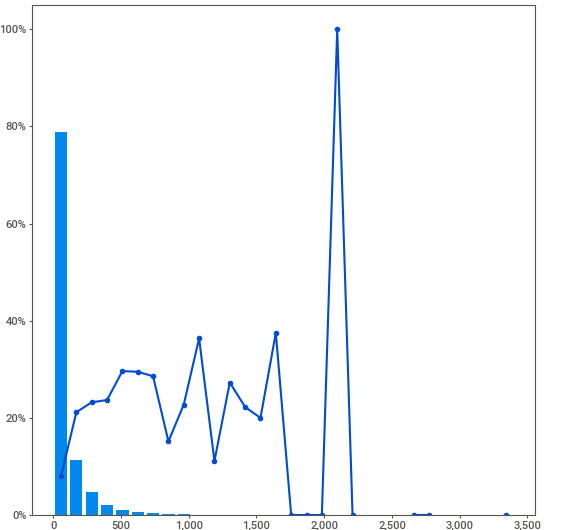
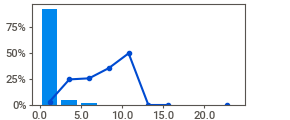
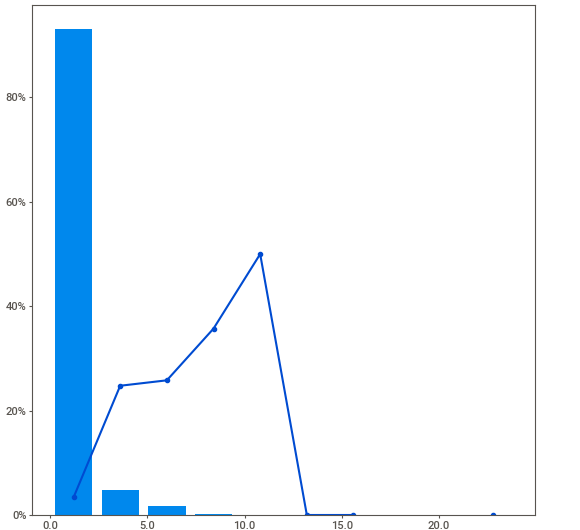
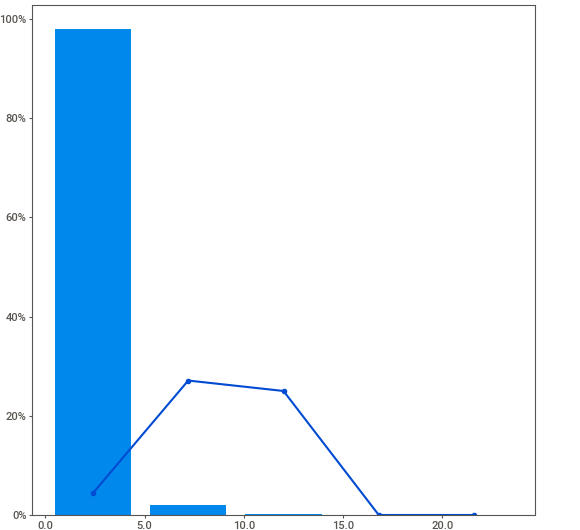
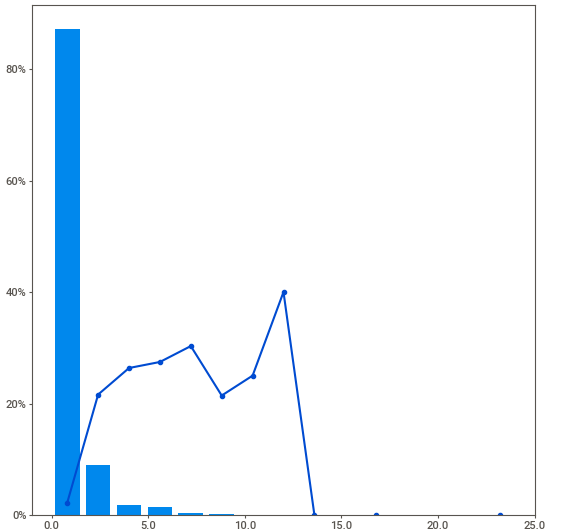
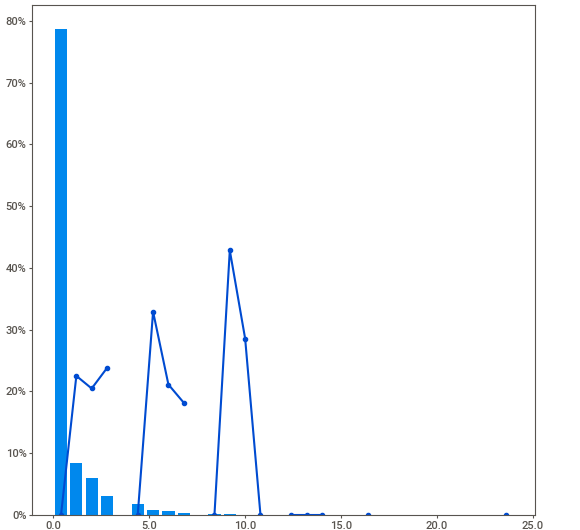
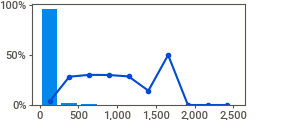
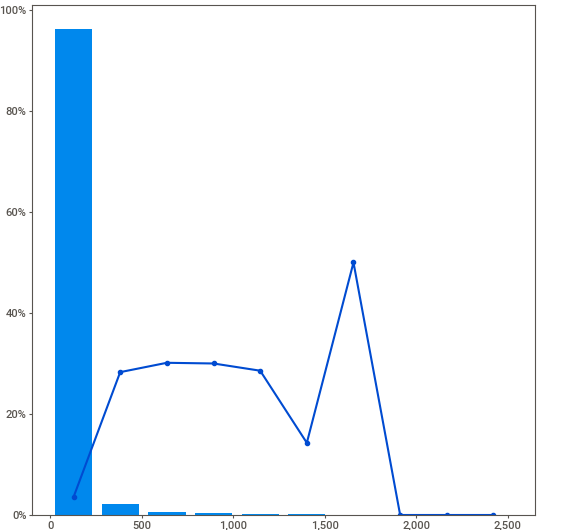
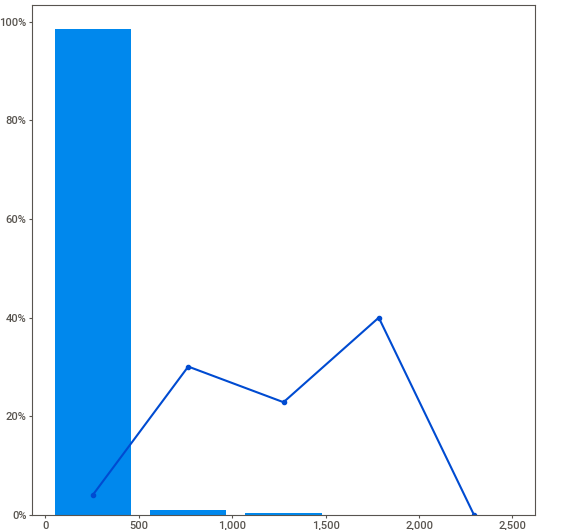
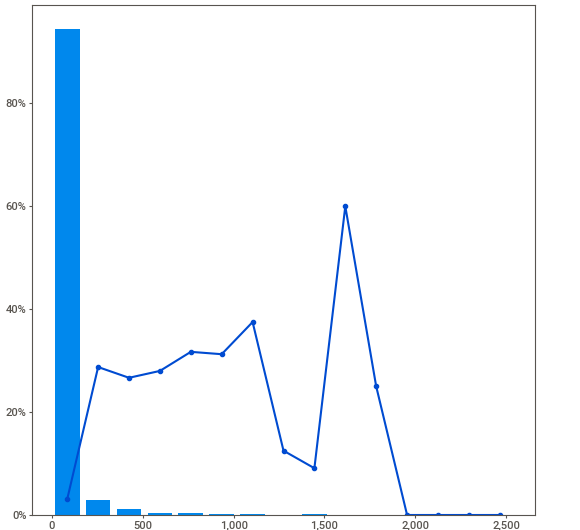
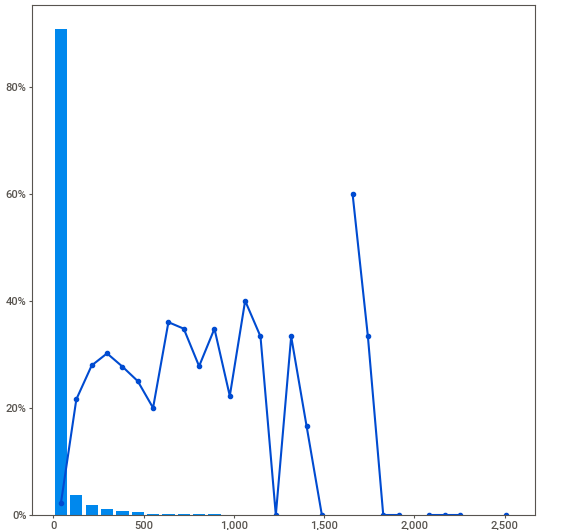
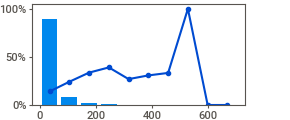
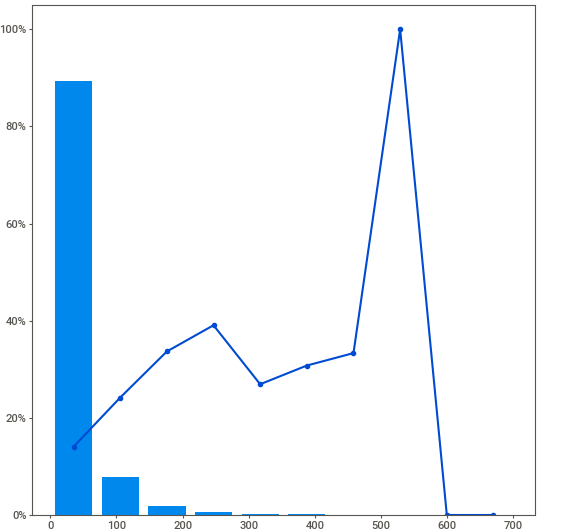
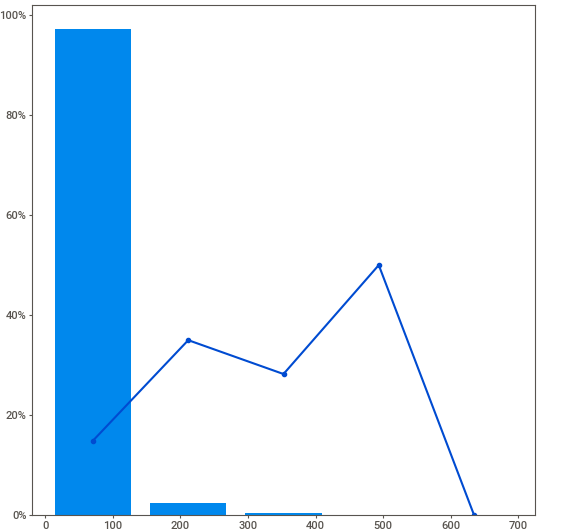
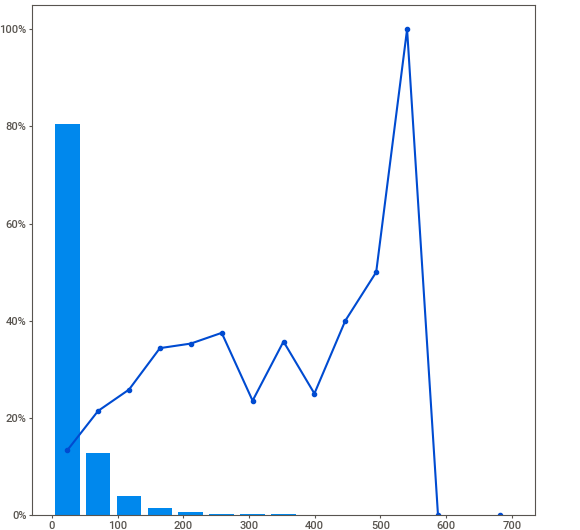
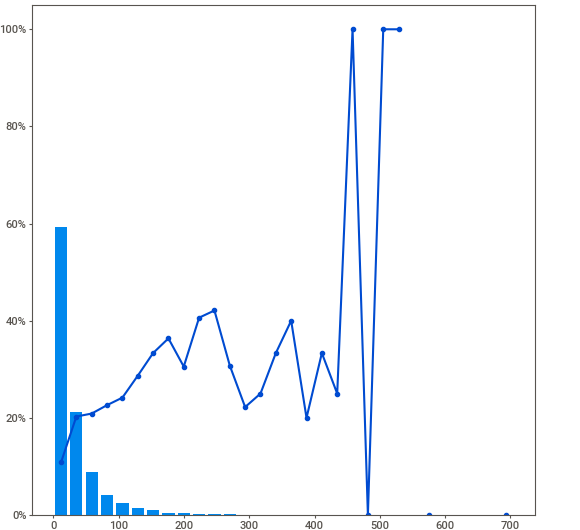
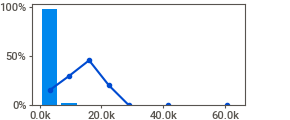
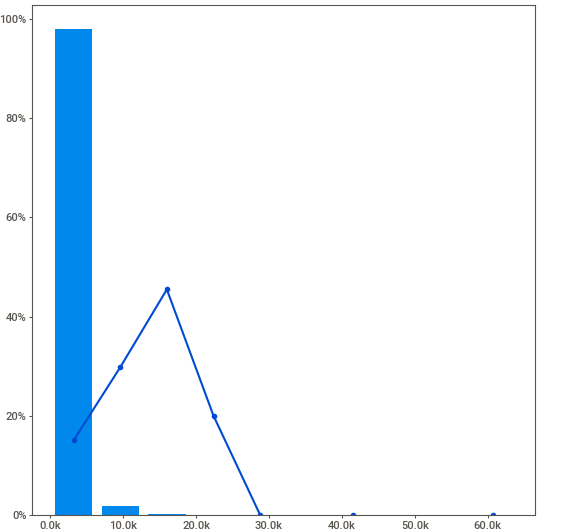
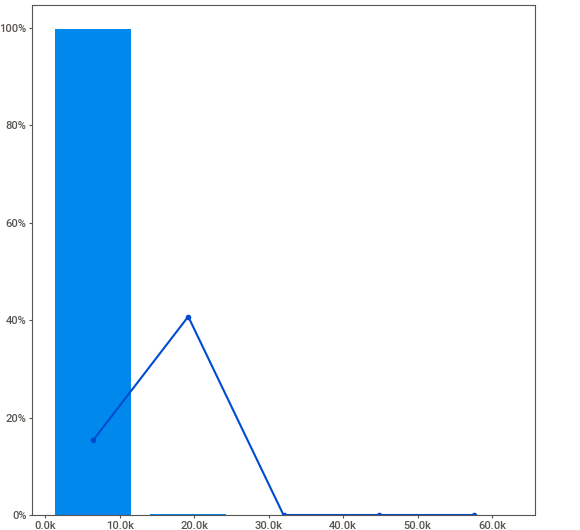
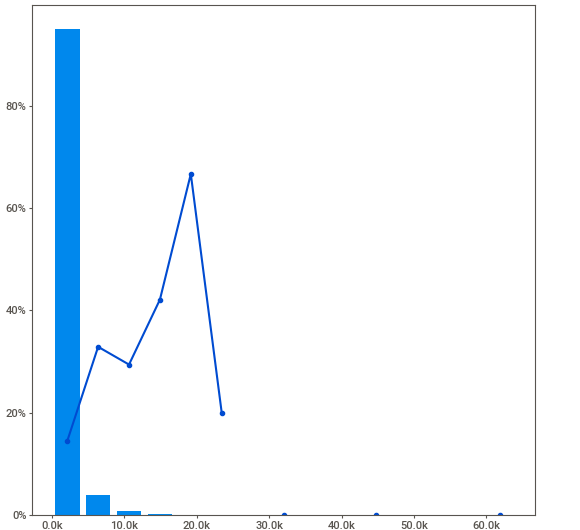
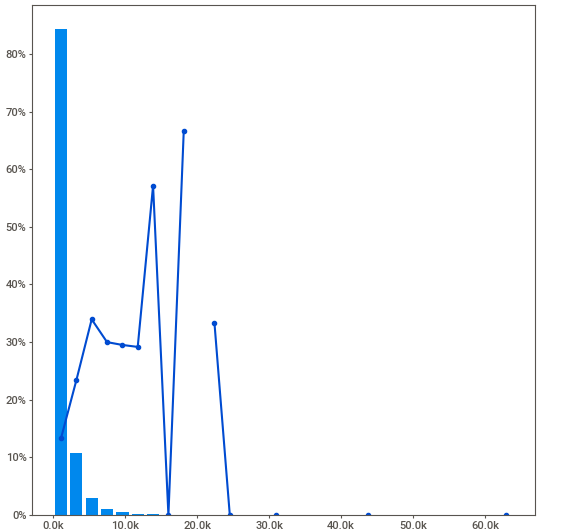
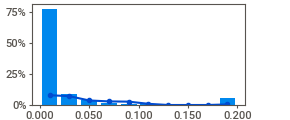
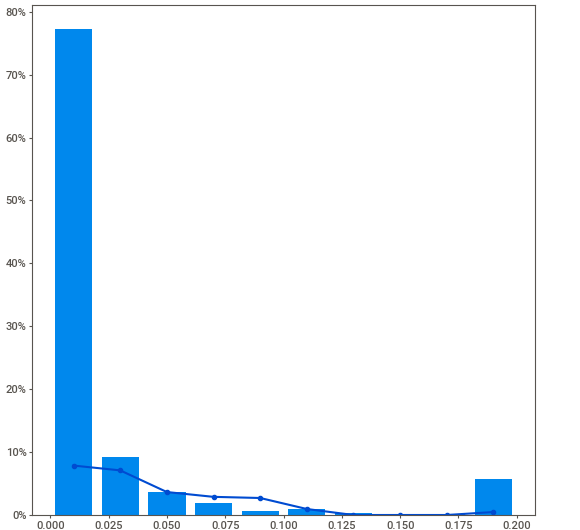
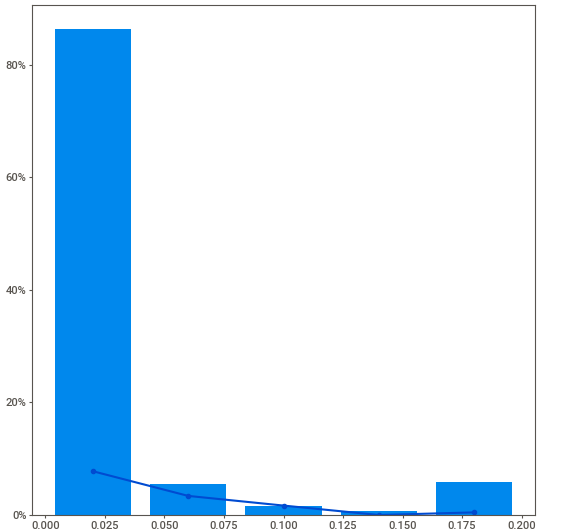
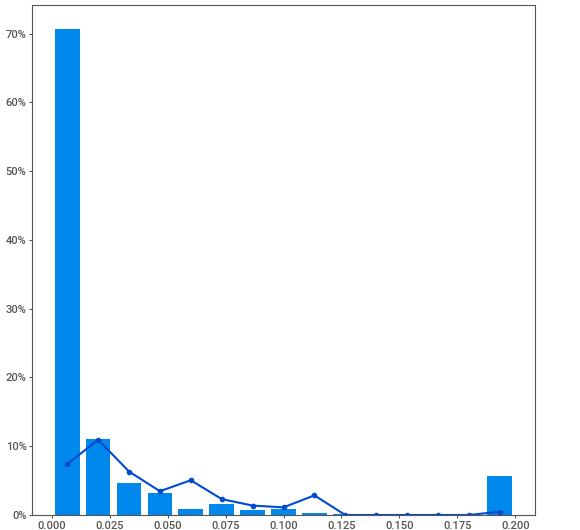
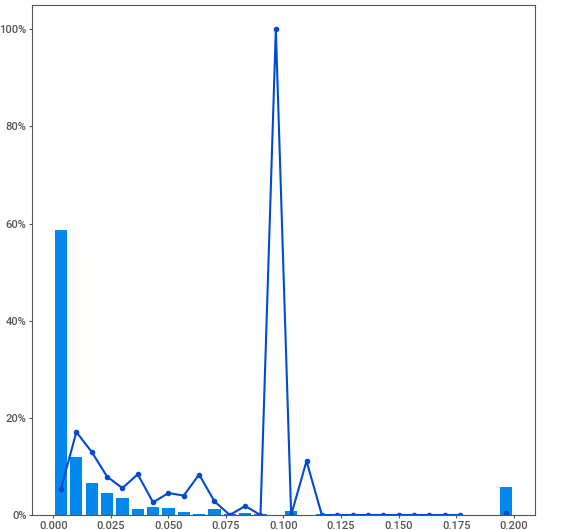
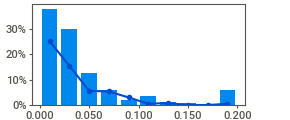
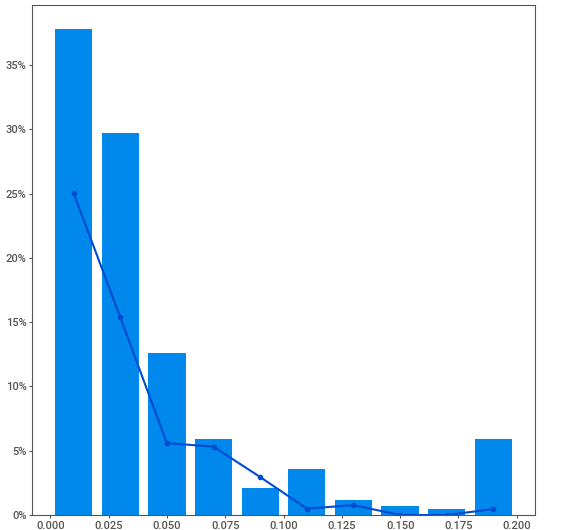
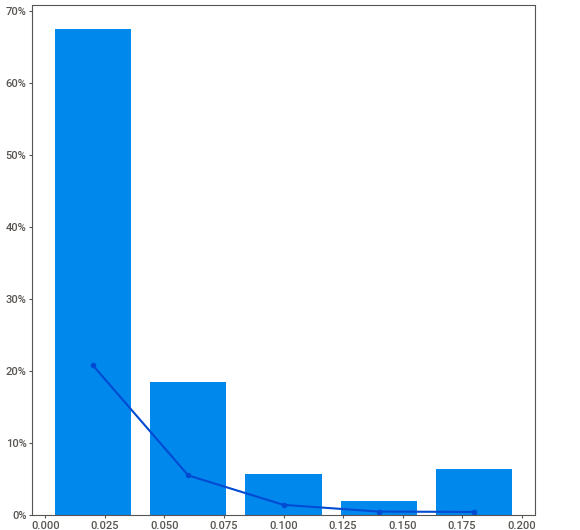
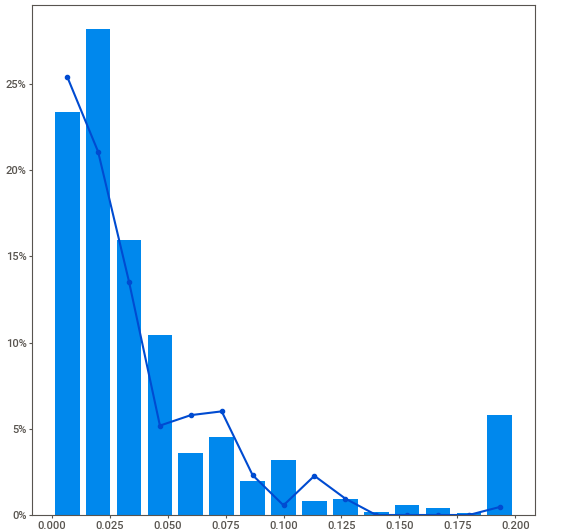
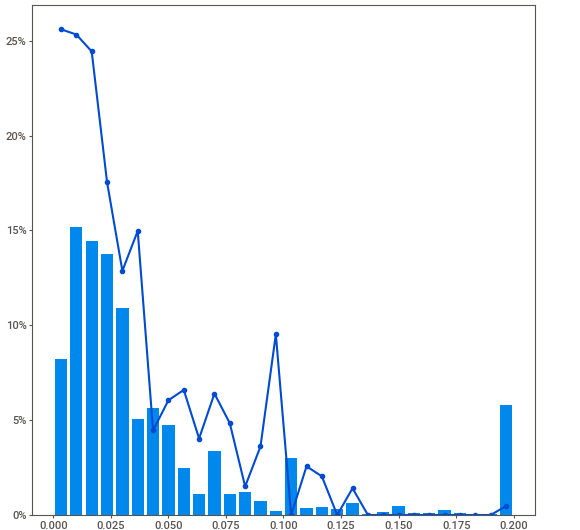
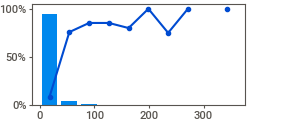
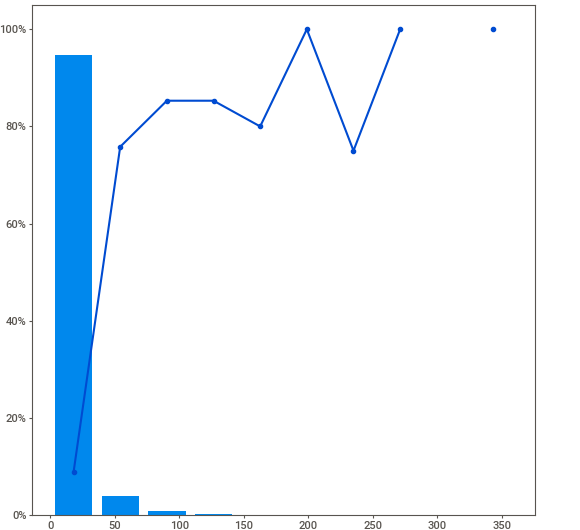
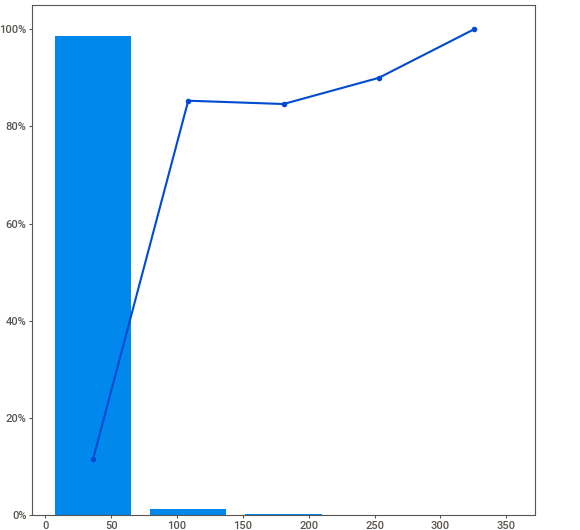
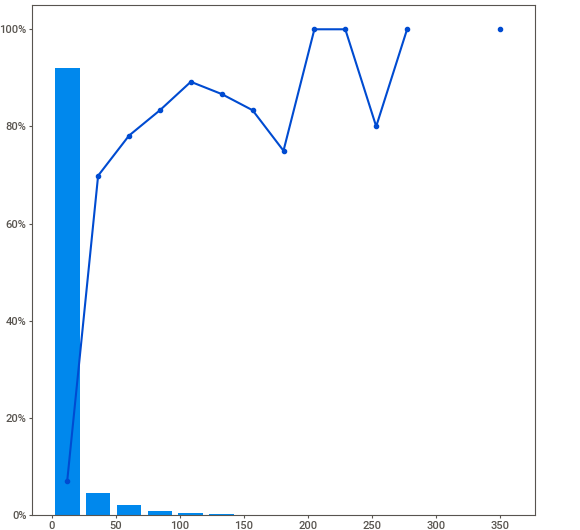
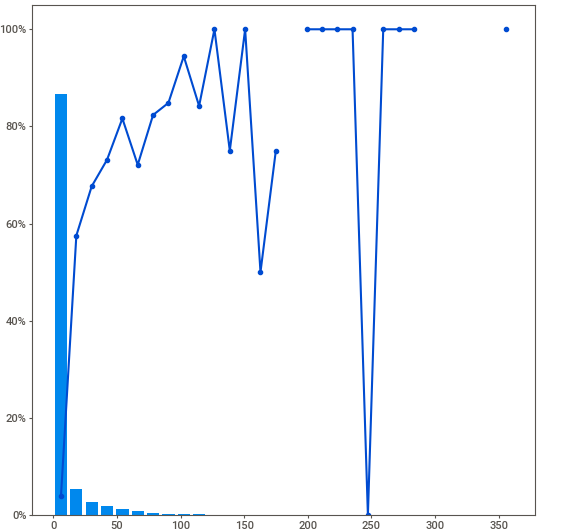
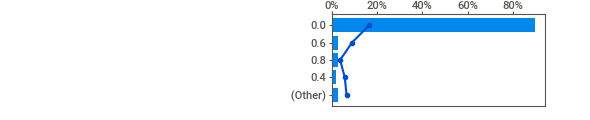
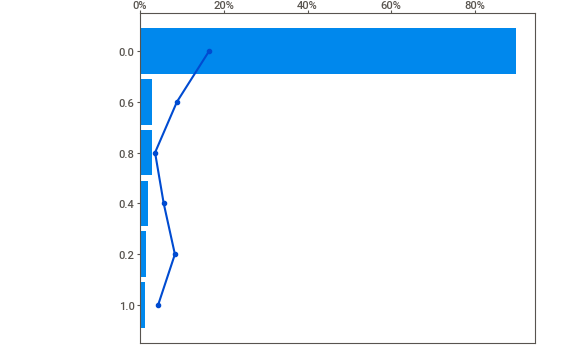
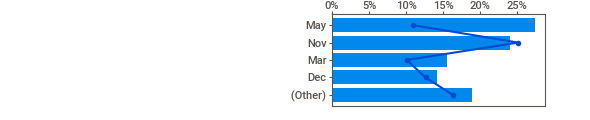
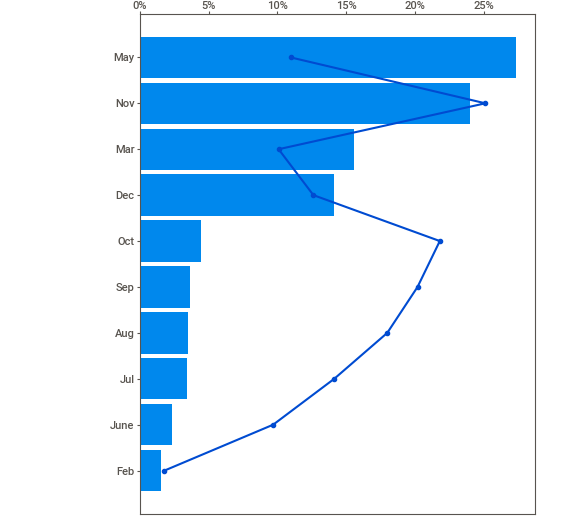
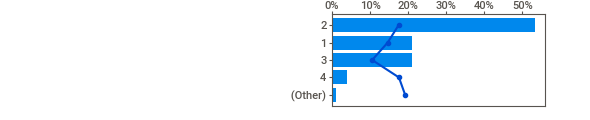
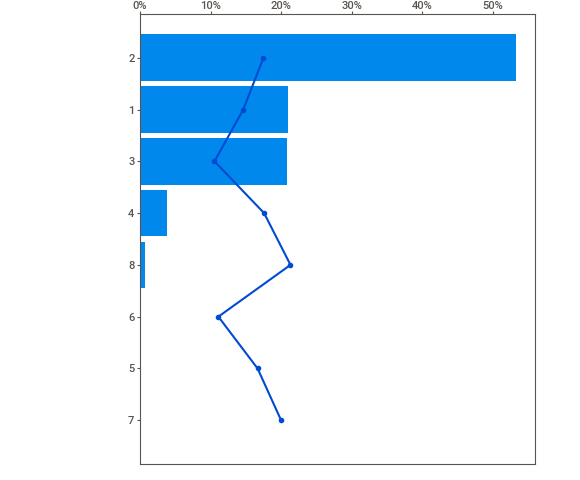
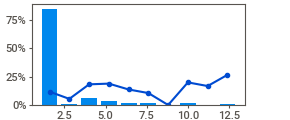
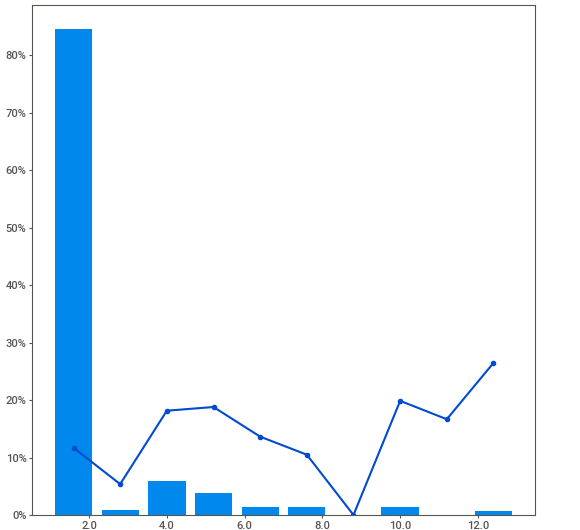
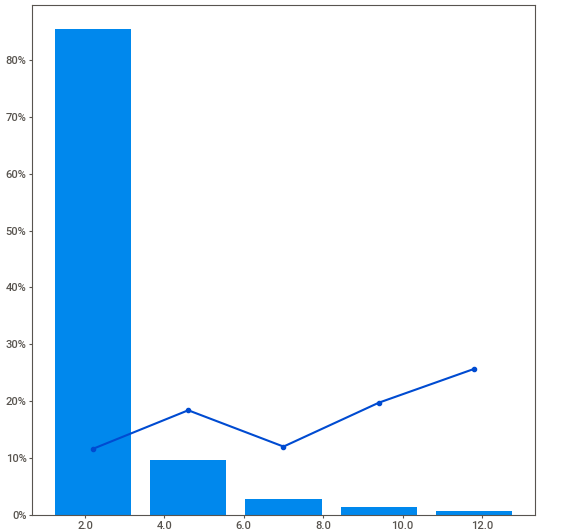
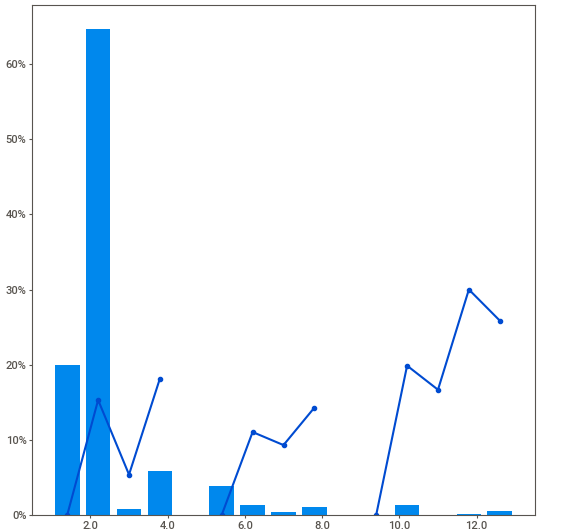
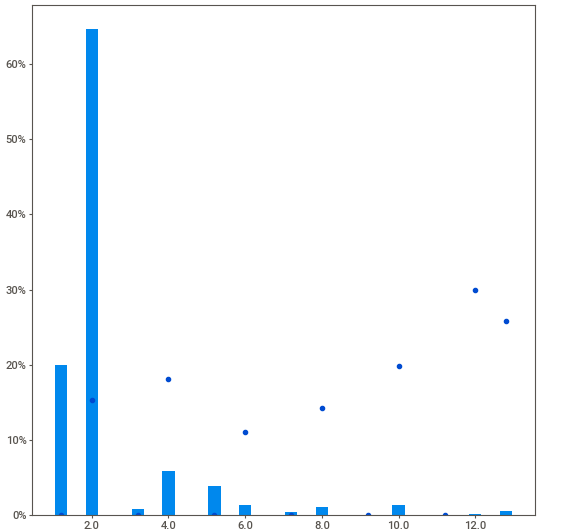
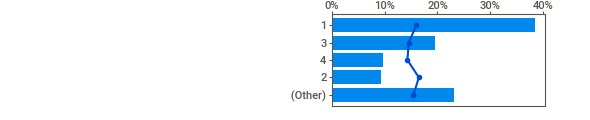
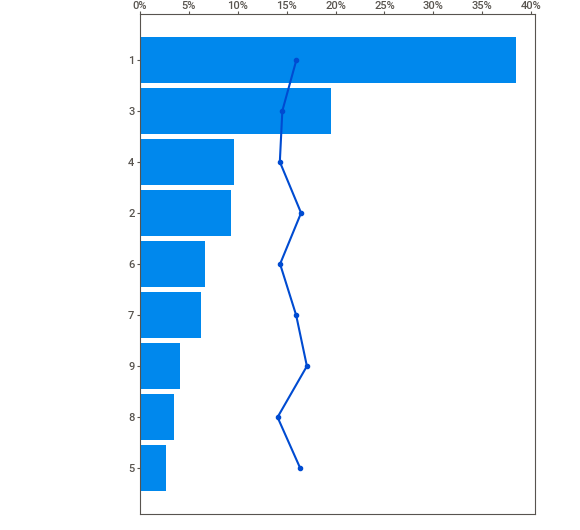
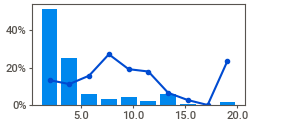
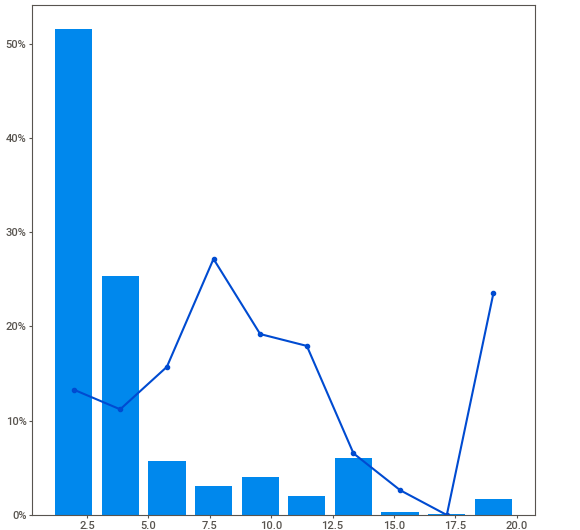
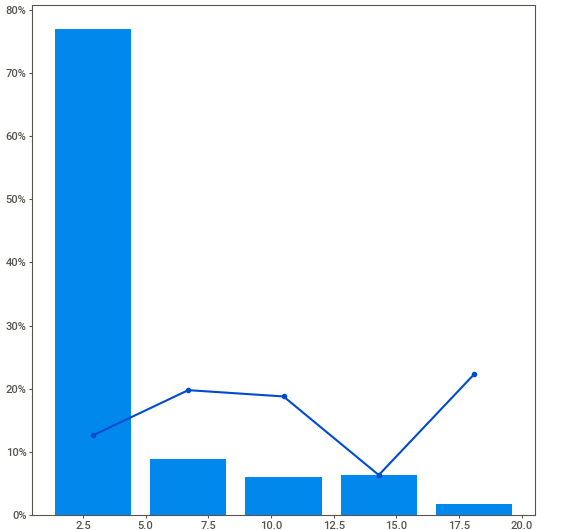
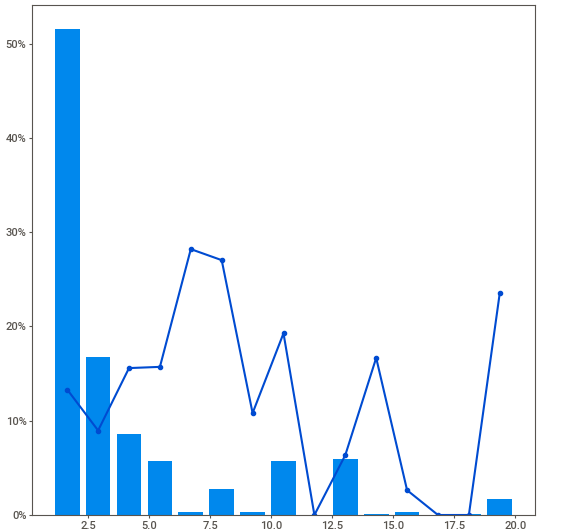
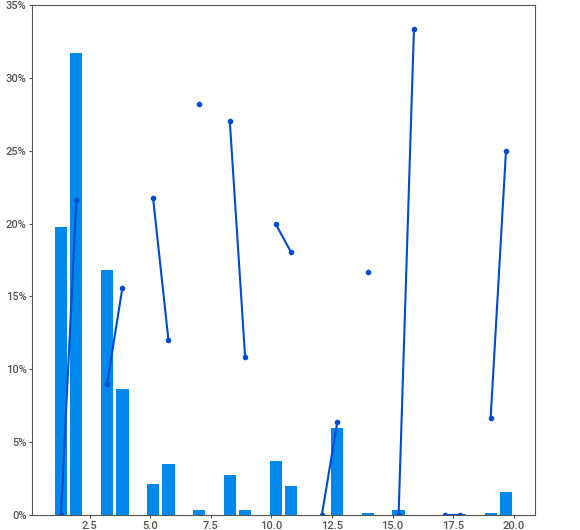
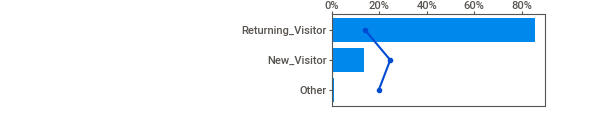
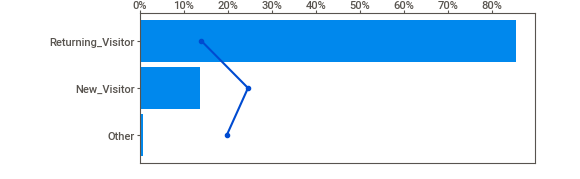
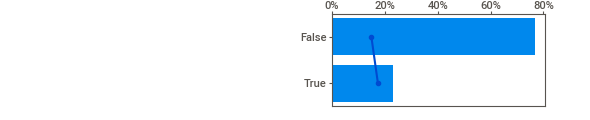
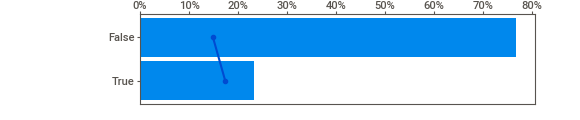
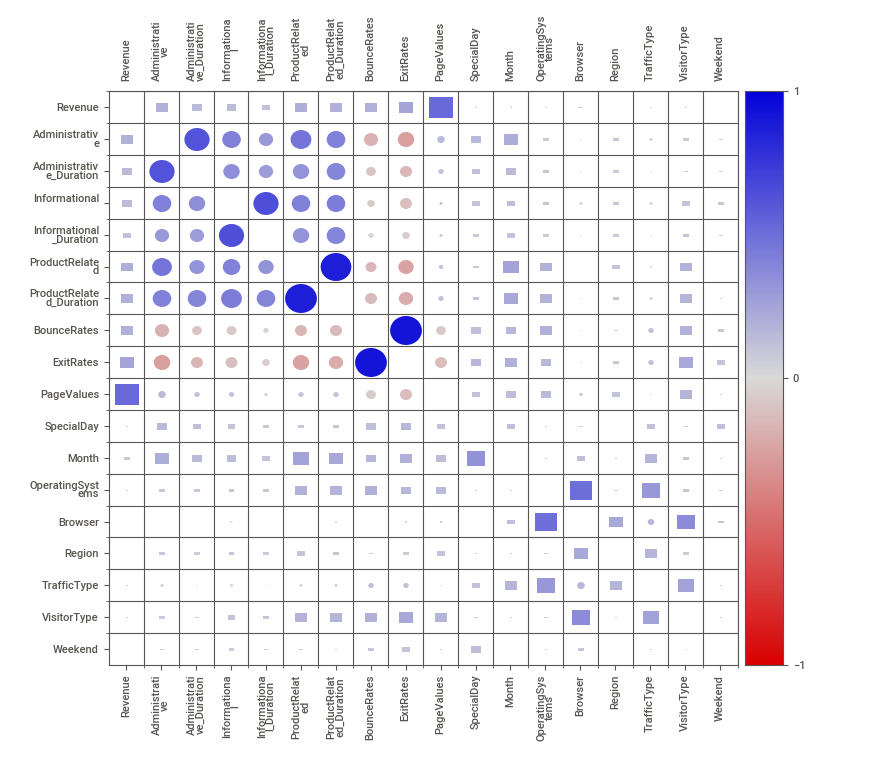
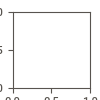

In [59]:
import sweetviz as sv

orig_data_report = sv.analyze(df, target_feat = 'Revenue')
orig_data_report.show_notebook()

#### 1.2. Advanced EDA
*Note: Sweetviz turned out to be extremely informative for this dataset. I'll add some more analysis as it is required in the assignment, but I am good with Sweetviz results.*

<AxesSubplot:>

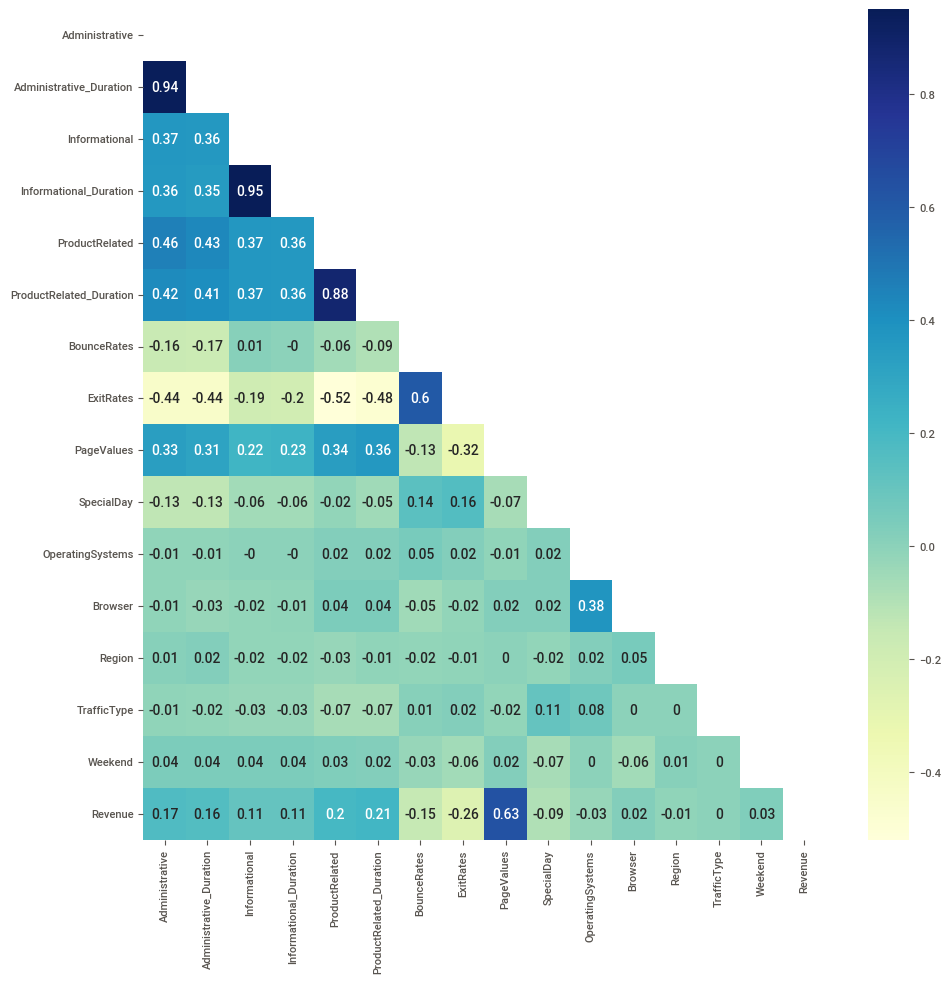

In [60]:
f = plt.figure(figsize=(11, 11))
corr = df.corr(method='spearman').round(2)

sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), cmap="YlGnBu", annot=True)

In [61]:

# First let's try to separate numerical and categorical features
numerical = [
    'Administrative', 'Administrative_Duration', 
    'Informational', 'Informational_Duration', 
    'ProductRelated', 'ProductRelated_Duration',
     'BounceRates', 'ExitRates', 'PageValues',
    ]
categorical = [
    'Browser', 'Month', 'Region', 'OperatingSystems', 'SpecialDay', 'VisitorType', 'Weekend'
]
label = 'Revenue'

# Sanity check - Should not print anything
for c in [label] + categorical + numerical:
    if not (c in df.columns):
        print (c)


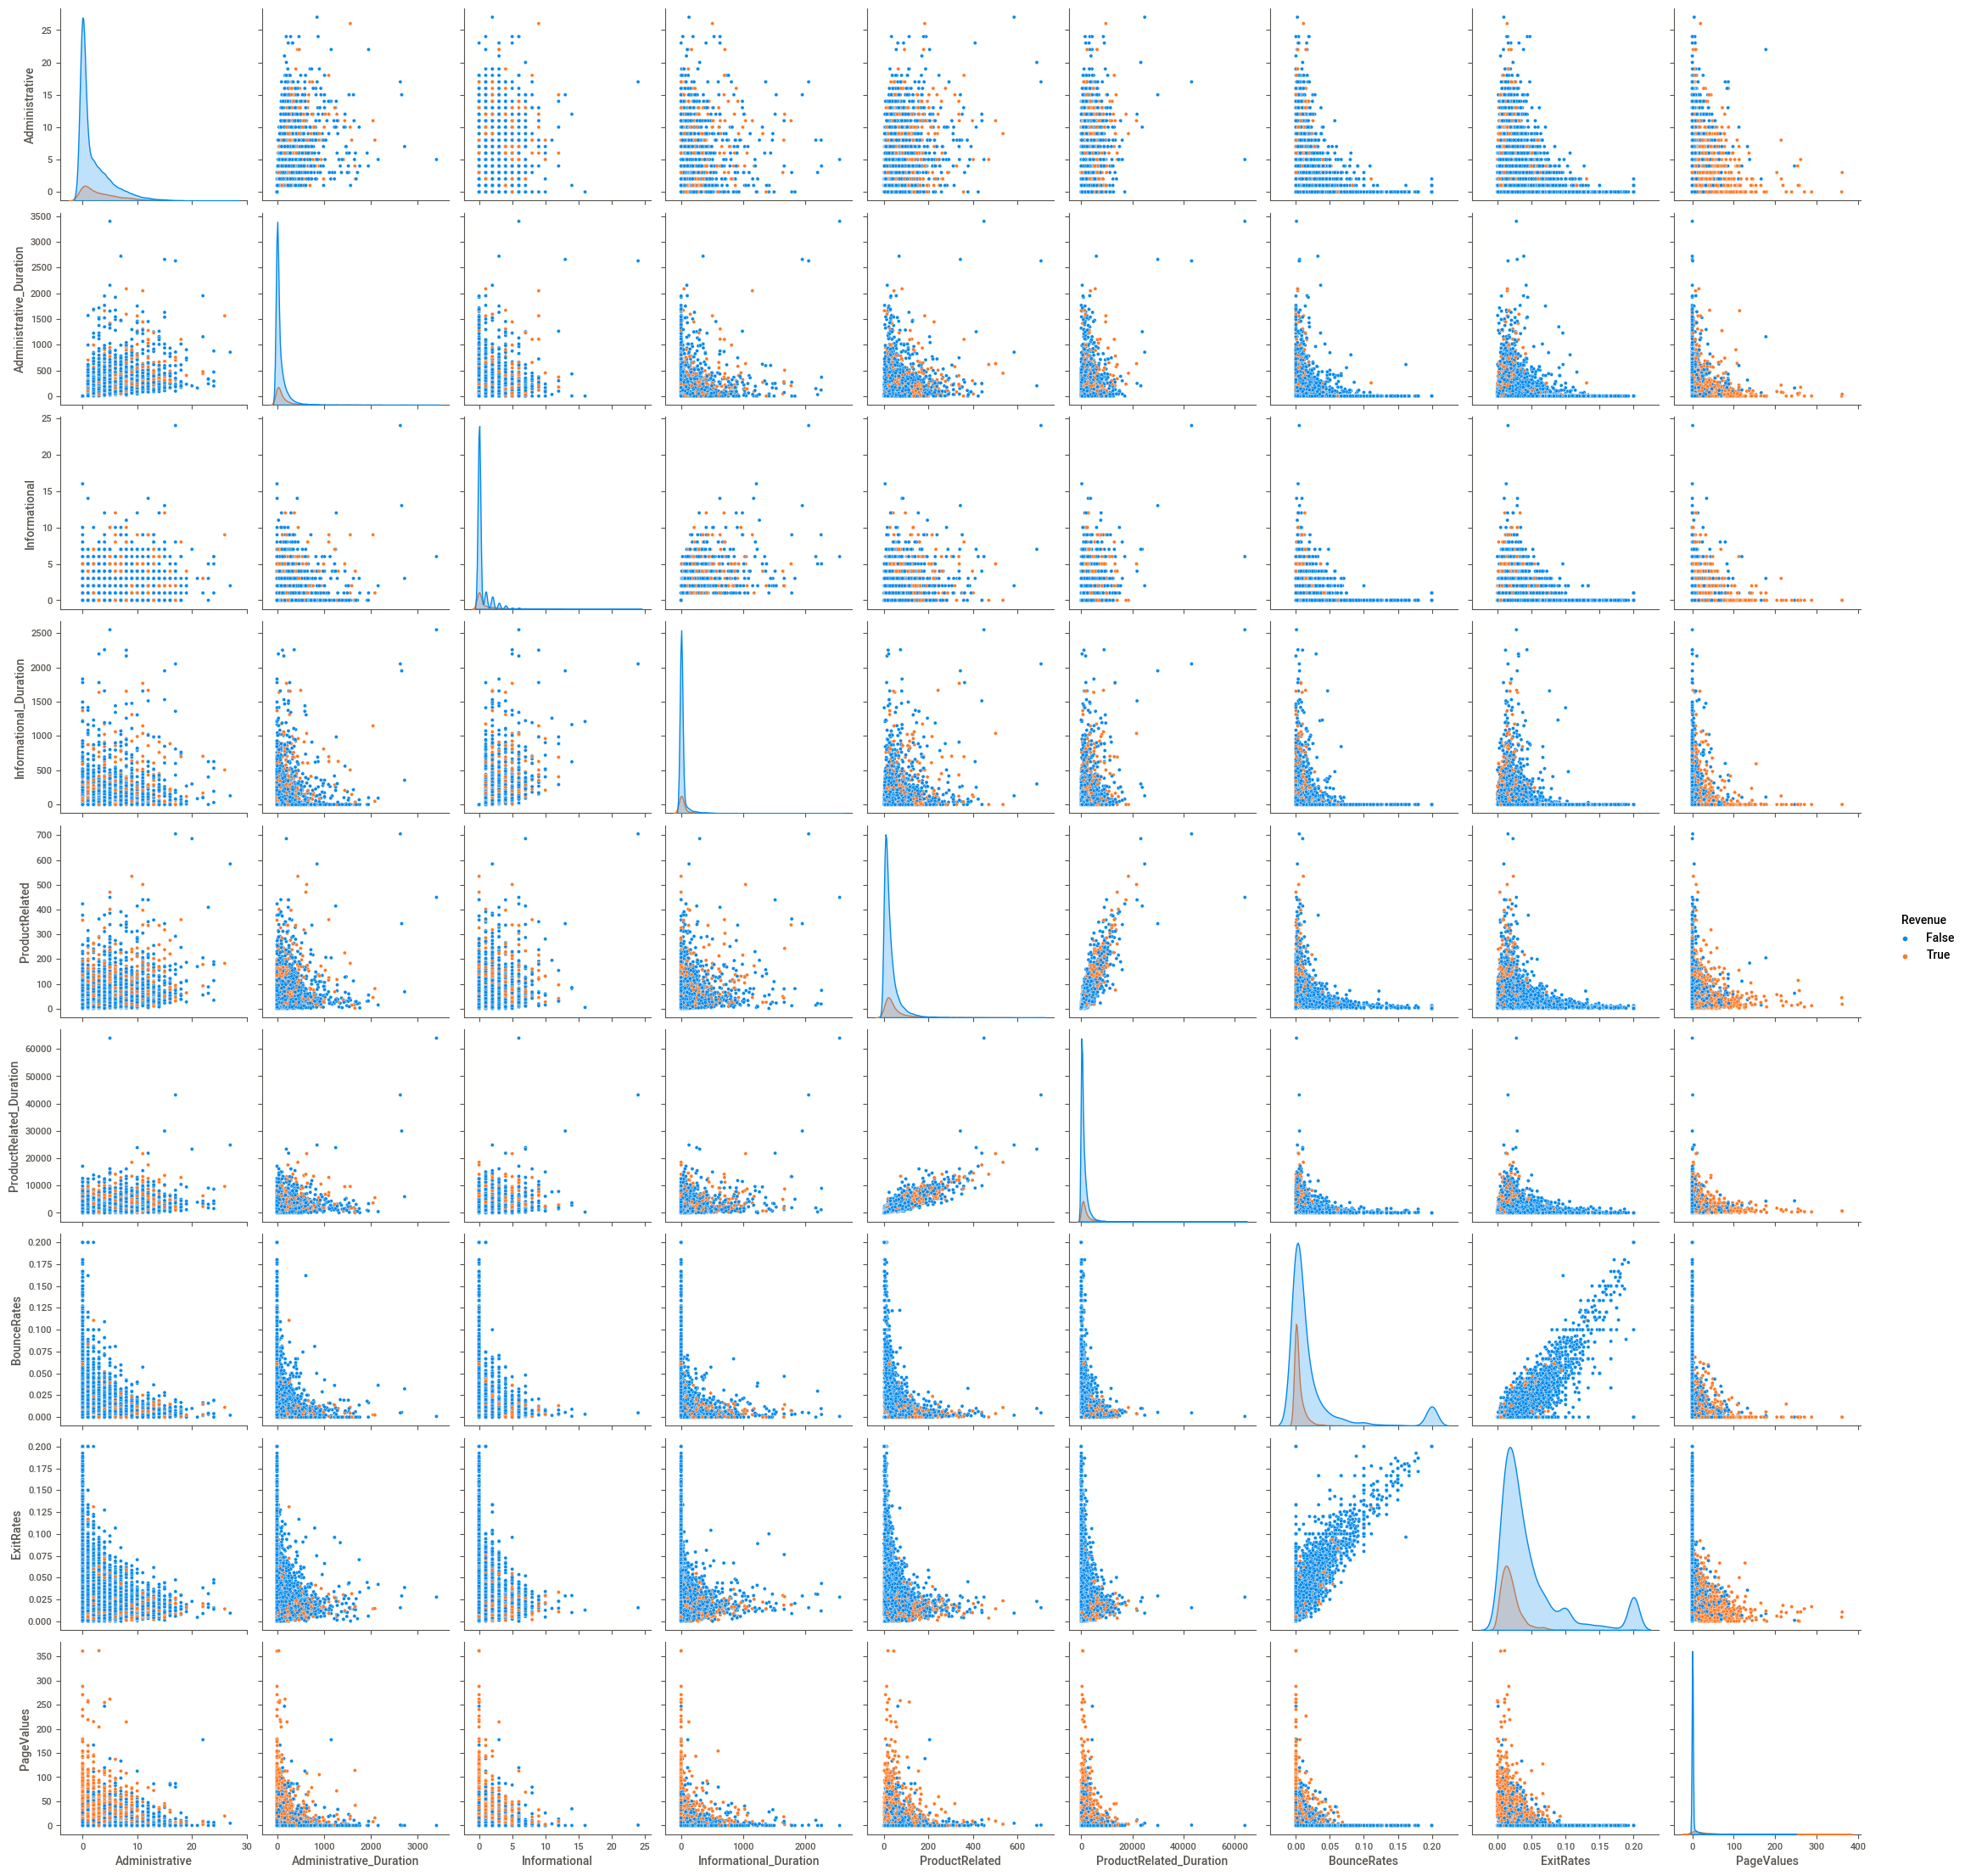

In [62]:
sns.pairplot(df[numerical + [label]], hue=label) 
plt.show()

#### 1.3 Train test split
Again, 10% of data for validation subset should be enough

In [65]:
df_train, df_valid = train_test_split(df, test_size=0.1, stratify=df.Revenue, random_state=42)

#### Feature selection
I am going to use sci-kit learn pipelines here.

In [67]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numeric_features = [
    'Administrative', 'Administrative_Duration', 
    'Informational', 'Informational_Duration', 
    'ProductRelated', 'ProductRelated_Duration',
     'BounceRates', 'ExitRates', 'PageValues',
    ]
categorical_features = [
    'Browser', 'Month', 'Region', 'OperatingSystems', 'SpecialDay', 'VisitorType', 'Weekend'
]

label = 'Revenue'


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
    
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)



In [70]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(class_weight = 'balanced', max_iter=500)
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("model", lr_model)]
)

model.fit(df_train, df_train[label])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Administrative',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'BounceRates', 'ExitRates',
                                                   'PageValues']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Browser', 'Month', 'Region',
                                                   'OperatingSystems',
                                                   'SpecialDay', 'VisitorType',
                                                   'Weekend'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [72]:
from sklearn.metrics import classification_report
print ('Results for train subset:')
print (classification_report(df_train[label], model.predict(df_train)))
print ('Results for validation subset:')
print (classification_report(df_valid[label], model.predict(df_valid)))



Results for train subset:
              precision    recall  f1-score   support

       False       0.96      0.88      0.91      8442
        True       0.54      0.78      0.63      1545

    accuracy                           0.86      9987
   macro avg       0.75      0.83      0.77      9987
weighted avg       0.89      0.86      0.87      9987

Results for validation subset:
              precision    recall  f1-score   support

       False       0.94      0.87      0.90       938
        True       0.49      0.70      0.58       172

    accuracy                           0.84      1110
   macro avg       0.72      0.78      0.74      1110
weighted avg       0.87      0.84      0.85      1110



Random forest classifier

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators = 100, min_samples_leaf=15)
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("model", rf_model)]
)

model.fit(df_train, df_train[label])


print ('Results for train subset:')
print (classification_report(df_train[label], model.predict(df_train)))
print ('Results for validation subset:')
print (classification_report(df_valid[label], model.predict(df_valid)))

Results for train subset:
              precision    recall  f1-score   support

       False       0.92      0.98      0.95      8442
        True       0.86      0.56      0.68      1545

    accuracy                           0.92      9987
   macro avg       0.89      0.77      0.82      9987
weighted avg       0.91      0.92      0.91      9987

Results for validation subset:
              precision    recall  f1-score   support

       False       0.91      0.98      0.94       938
        True       0.82      0.47      0.60       172

    accuracy                           0.90      1110
   macro avg       0.86      0.73      0.77      1110
weighted avg       0.90      0.90      0.89      1110

